# Image Caption Generator

## Introduction
<img src="https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/beautiful-smiling-cute-baby-royalty-free-image-1580143386.jpg" width="400">
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;<b>Can you caption me?</b>

Without the deeplearning and AI algorithms, this problem was very different to solve even for computer scientists because normal computers cannot understand the images as humans do. With the aid of Deep learning we can solve this problem easily.

Image caption generator is an interesting task where both computer vision techniques and natural language processing techniques are explored to recognize the context of an image and outline them in a natural language like English. The generation of captions from an image has many practical benefits like aiding the visually impaired and enabling the automation of labelling the millions of images uploaded to the internet every day. One of the image captioning approaches Top-down approach is used, where we generate a semantic representation of an image that is then decoded into a caption using various architectures, such as recurrent neural networks (RNN).


## Project Objective:
The Objective of our project is to build a working model of image caption generator by using CNN (Conventional Neural networks) with LSTM (Long short term memory). Image features will be extracted and then we feed to the LSTM model for generating image captions. In simple words, Our goal is to build a model which takes an image as input and outputs its caption.


## Motivation
In the real world, The image captioning has many applications which include Self-driving cars, Surveillance cameras and especially for aiding the blind people. With this image captioning model we can create a product which will assist the blind on the roads without the help of other people.

### Importing libraries.

In [57]:
import numpy as np
from numpy import array
import string,os,glob,pickle,requests
from io import BytesIO
import tensorflow as tf
from IPython.core.display import display, HTML
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
from PIL import Image,ImageFile
from pickle import dump, load
from time import time
from keras.layers import LSTM, Embedding, Dense,Activation, Reshape, Dropout
from keras.optimizers import Adam
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import tensorflow
from IPython.display import Image

## Data Collection:

Our dataset is built from the images pulled from different Flickr groups and we used Kaggle to get this dataset. It is mainly categorized into two parts.
1.    Flickr_8K_dataset: It consists of around 8000 images in JPEG format of different sizes and shapes.
2.    Flickr_8K_text: It consists of the main file named Flickr8k.token which has the information about the image name and its respective captions separated by a new line. There are 5 captions paired for each image.

These images are segregated as follows:

Training Set — 6000 images

Dev Set — 1000 images

Test Set — 1000 images


<a href="https://www.kaggle.com/shadabhussain/flickr8k?select=Flickr_Data">1.Flicker dataset --->1.14 GB</a>

<a href="https://www.kaggle.com/incorpes/glove6b200d">2.Glove embeddings --->661.31 MB </a>


 

## Understanding the data

In [2]:
#READING THE FLICKR TOKEN FILE
def read_file(file_path):
    file = open(file_path, 'r')
    text = file.read()
    file.close()
    return text
file_path = "./Flickr_Data/Flickr_TextData/Flickr8k.token.txt"
doc = read_file(file_path)
print(doc[:500])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7


In [3]:
#Extracting the image descriptions from the tokens file

In [4]:
def store_desc(doc):
    mapping = defaultdict(list)
    for line in doc.split('\n'):
    #split each line
        tokens = line.split()
        if len(line) < 2:
            continue
        # Spliting image id and image description
        ids, desc = tokens[0], tokens[1:]
        # Storing image id
        ids = ids.split('.')[0]
        desc = ' '.join(desc)
        mapping[ids].append(desc)
    return mapping
descriptions = store_desc(doc)
print('Total descriptions: %d ' % len(descriptions))

Total descriptions: 8092 


In [5]:
list(descriptions.items())[:3]

[('1000268201_693b08cb0e',
  ['A child in a pink dress is climbing up a set of stairs in an entry way .',
   'A girl going into a wooden building .',
   'A little girl climbing into a wooden playhouse .',
   'A little girl climbing the stairs to her playhouse .',
   'A little girl in a pink dress going into a wooden cabin .']),
 ('1001773457_577c3a7d70',
  ['A black dog and a spotted dog are fighting',
   'A black dog and a tri-colored dog playing with each other on the road .',
   'A black dog and a white dog with brown spots are staring at each other in the street .',
   'Two dogs of different breeds looking at each other on the road .',
   'Two dogs on pavement moving toward each other .']),
 ('1002674143_1b742ab4b8',
  ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
   'A little girl is sitting in front of a large painted rainbow .',
   'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it

## Process Flow:

<img src="PIC1.png" width="500">

Below are the KDD(Knowledge Discovery from Data) steps followed in our project to achieve our goal. They are as follows:<br>

Below are the KDD(Knowledge Discovery from Data) steps followed in our project to achieve our goal. They are as follows:<br>

<b>Step 1: Data Collection: </b> Initially, we begun by collecting the dataset that perfectly fits for our goal. For this, we pulled the dataset from Kaggle which has two parts. a) Image dataset and b) Caption Dataset.<br>

<b>Step 2: Data  Cleaning: </b> Data cleaning is the process of preparing data for analysis by removing or modifying data that is incorrect, incomplete, irrelevant, duplicated, or improperly formatted. In our dataset, lots of noisy data like numbers punctuations, special characters etc were identified and removed which will help in increasing our accuracies while providing results.<br>

<b>Step 3: Data Preprocessing of images:</b> Data preprocessing is a data mining technique that involves transforming raw data into an understandable format. In our project, we pre-process every image by converting into a fixed-sized vector which can then be fed as input to the neural network. For this purpose, we opt for transfer learning by using the InceptionV3 model (Convolutional Neural Network) created by Google Research.<br>

<b>Step 4: Data Preprocessing of Captions:</b> Captions are something that we want to predict. So, we encode each word into a fixed-sized vector. It is pre-processed to represent every unique word in the vocabulary by an integer (index) thus representing every word by an integer.<br>

<b>Step 5: Data integration</b> Data Integration is a technique that involves combining data from multiple heterogeneous data sources into a coherent data store and provide a unified view of the data. In our case, we combine the partial text embedding with the image feature to the model.

<b>Step 6: Data Modelling:</b> Data modelling refers to a group of processes in which multiple sets of data are combined and analyzed to uncover relationships or patterns. The goal of data modelling is to use past data to inform future efforts. In our model, we perform a Dense Captioning technique where we initially classify an object followed by captioning.  <br>

<b>Step 7: Performance Evaluation:</b> It is performed to evaluate the knowledge gained by a data model in extracting the right information. To understand how good the model is, we tried to generate captions on images from the test dataset and evaluate the results.

## Data Cleaning

  In reality, The data is not readily available to feed into the model and it is not necessarily clean which will have a significant impact on the analysis. Our dataset contains noisy data like numbers, some special characters and symbols. 
  
  In this step, we have deleted the numbers, punctuations, and extra white spaces also converted the words into the lower case. The method vocab used below will give us the number of unique words in our dataset which contains a total of 8763 unique words.

In [6]:
def descriptions_cleaning(descriptions):
    #all_desc = set()
    for key, list_of_descriptions in descriptions.items():
        for i in range(len(list_of_descriptions)):
            each_desc = list_of_descriptions[i]
            # tokenize and converting to lower case
            each_desc = each_desc.split()
           # all_desc.update(each_desc)
            each_desc = [word.lower() for word in each_desc]
            # removing punctuations and hanging s and a.
            each_desc = [w.translate(str.maketrans('', '', string.punctuation)) for w in each_desc]
            each_desc = [word for word in each_desc if len(word)>1]
            # remove tokens with numbers in them
            each_desc = [word for word in each_desc if word.isalpha()]
            # store back to string
            list_of_descriptions[i] =  ' '.join(each_desc)        
descriptions_cleaning(descriptions)

In [7]:
def vocab(descriptions):
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc
vocabulary = vocab(descriptions)
print('Total Vocabulary Size: %d' % len(vocabulary))

Total Vocabulary Size: 8763


In [8]:
descriptions['1002674143_1b742ab4b8']

['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
 'little girl is sitting in front of large painted rainbow',
 'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
 'there is girl with pigtails sitting in front of rainbow painting',
 'young girl with pigtails painting outside in the grass']

In [9]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
save_descriptions(descriptions, 'descriptions.txt')

## Loading the training set

In [10]:
# load a pre-defined list of photo identifiers
def read_train_identifier(file_path):
    doc = read_file(file_path)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        dataset.append(line.split('.')[0])   #extracting image identifier
    return set(dataset)
# load training dataset (6K)
file_path = './Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
train = read_train_identifier(file_path)
print('Dataset: %d' % len(train))

Dataset: 6000


In [11]:
# Loading the image file names to the memory.

In [12]:
images = './Flickr_Data/images/'
img = glob.glob(images + '*.jpg')
img[:3]

['./Flickr_Data/images\\1000268201_693b08cb0e.jpg',
 './Flickr_Data/images\\1001773457_577c3a7d70.jpg',
 './Flickr_Data/images\\1002674143_1b742ab4b8.jpg']

In [13]:
#saving train image file names into a list
path_train_images = './Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(path_train_images, 'r').read().strip().split('\n'))
list_train_img = []
for i in img: 
    if i[len(images):] in train_images:
        list_train_img.append(i)
list_train_img[:3]        

['./Flickr_Data/images\\1000268201_693b08cb0e.jpg',
 './Flickr_Data/images\\1001773457_577c3a7d70.jpg',
 './Flickr_Data/images\\1002674143_1b742ab4b8.jpg']

In [14]:
#saving test image file names into a list
path_test_images = './Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'
test_images = set(open(path_test_images, 'r').read().strip().split('\n'))
list_test_img = []
for i in img: 
    if i[len(images):] in test_images:
        list_test_img.append(i)
list_test_img[:3]        

['./Flickr_Data/images\\1056338697_4f7d7ce270.jpg',
 './Flickr_Data/images\\106490881_5a2dd9b7bd.jpg',
 './Flickr_Data/images\\1082379191_ec1e53f996.jpg']

Creating the sequences by including a start and stop token at the beginning/end. We will later use the start token to begin the process of generating a caption and the stop token in the generated text will tell us to know we are done.

In [15]:
def load_clean_descriptions(filename, dataset):
    doc = read_file(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
#All the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

Since each image has 5 different captions so the train data 6000 images has total 30000 captions.

## Creating the Training Set for model

we encoded the images to 299*299 to create the training set.So we will encode new images to present them for captioning.

In [16]:
def convert(image_path):
    # resizing all the images to size 299x299 for  the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x
def encodeImage(img):
  img = img.resize((299, 299), Image.ANTIALIAS)
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  x = model_1.predict(x) # Get the encoding vector for the image
  x = np.reshape(x, x.shape[1] )
  return x

## Data Preprocessing — Images

we have used Glove for text embeddeding and InceptionV3 to extract features from the images. These two used to extract features from raw text and the images. We had a pre-trained model for that we have transferred the learning with our train data because without this way the model would take more time and more training.

In [17]:
# Inception v3 model
model = InceptionV3(weights='imagenet')

In [18]:
# Removing the last layer from the inception v3 for creating new model
model_1 = Model(model.input, model.layers[-2].output)

In [19]:
#Encoding the given image into a vector of size (2048, )
def transform(image):
    image = convert(image)
    vec = model_1.predict(image) # Get the encoding vector for the image
    vec = np.reshape(vec, vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return vec

Encoding all the train images and this will takes time

In [20]:
start = time()
transform_train = {}
for img in list_train_img:
    transform_train[img[len(images):]] = transform(img)
print("Total Time taken in seconds =", time()-start)

Total Time taken in seconds = 2426.39560174942


This process involves looping over every image and this can take a while to perform we will save it to a pickle file as per below method. This saves the time needed to completely reprocess all of the images.

In [21]:
# Saving the train features 
with open("./Flickr_Data/save/encoded_train_images.pkl", "wb") as transformed_pickle:
    pickle.dump(transform_train, transformed_pickle)

Encoding all the test images and this will takes time

In [22]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
transform_test = {}
for img in list_test_img:
    transform_test[img[len(images):]] = transform(img)
print("Total Time taken in seconds =", time()-start)

Total Time taken in seconds = 125.74300050735474


In [23]:
# Saving the test features 
with open("./Flickr_Data/save/encoded_test_images.pkl", "wb") as transformed_pickle:
    pickle.dump(transform_test, transformed_pickle)

In [24]:
train_features = load(open("./Flickr_Data/save/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


## Data Preprocessing — Captions
We can consider only the words which have been repeated atleast certain amount times. In this case, atleast 10 times. So this will reduce to 1651 words from 7578 words. Two dictionaries "idtoword" and "wordtoid" are for the mapping from descriptions to id and id and descriptions mapping.

In [25]:
# Removing rarely occuring words in the corpus
threshold = 10
id = 1
count_of_words,idtoword,wordtoid = {},{},{}
for sent in all_train_captions:
    for w in sent.split(' '):
        count_of_words[w] = count_of_words.get(w, 0) + 1
new_vocab = [w for w in count_of_words if count_of_words[w] >= threshold]
print('Total words after threshold %d -> %d' % (len(count_of_words), len(new_vocab)))
for w in new_vocab:
    wordtoid[w] = id
    idtoword[id] = w
    id += 1
new_vocab_size = len(idtoword) + 1 # one for appended 0's
new_vocab_size 

Total words after threshold 7578 -> 1651


1652

Calcuate the max length of the description so that we can use this length as reference in the caption generation.

In [26]:
# converting to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the max length of the description
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


## Data Preparation using Generator Function

This is the main part of the image captioning. This function prepares the data which will be suitable to be given as input to the deep learning model. 
First images with 2048 feature-length vector and partial caption are given as input to the model. Starting, we provide only the image vector and the first word as input and try to predict the second word
     
   Input = Image_1 + ‘startseq’; Output = ‘the’

After that we provide image vector and the first two words as input and try to predict the third word, i.e.:
    
  Input = Image_1 + ‘startseq the’; Output = ‘dog’ And so on...
  

| Image Feature Vector | Partial Caption | Targetword |
| --- | --- | --- |
| Image_1 |startseq | black |
| Image_1 |startseq black | dog |
| Image_1 |startseq blackdog | is |
| Image_1 |startseq black dog is | running |
| Image_1 |startseq black dog is running| through |
| Image_1 |startseq black dog is running through| the |
| Image_1 |startseq black dog is running through the | grass |
| Image_1 |startseq black dog is running through the grass| endseq |

In [27]:
def data_generator(descriptions, photos, wordtoid, max_length, num_photos_per_batch):
    X1, X2, y = [], [],[]
    n=0
    # loop for ever over images
    while True:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            # looping for 5 descriptions
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoid[word] for word in desc.split(' ') if word in wordtoid]
                # creating a training case for each sequence and outcome.
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=new_vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = [],[],[]
                n=0

## Loading Glove Embeddings
    
   The gloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.
   
   In our case, Loading Glove Embedding is performed to get features for our vocabulary words. To be specific, the words with the closest meaning will have least euclidean distance in the vector space representation.

In [28]:
# Load Glove vectors
glove_dir = './Flickr_Data/Flickr_TextData/'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


## Building the Neural Network

Long short-term memory is an artificial recurrent neural network architecture used in the field of deep learning. LSTM have feedback connections which can process entire sequences of Data. They are a type of RNN (recurrent neural network) which is well suited for sequence prediction problems. LSTM can carry relevant information throughout the processing of inputs and discards non-relevant information.

An embedding matrix is created from Glove embeddings and this will directly be copied to the weight matrix of the neural network. The LSTM(Long Short Term Memory) layer is to process the sequence input text data. (partial captions in our case).

<img src="PIC3.png" width="900">

In [29]:
embedding_dim = 200
embedding_matrix = np.zeros((new_vocab_size, embedding_dim))
for word, i in wordtoid.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape        

(1652, 200)

In [30]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(new_vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(new_vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [31]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [32]:
model.layers[2]

In [33]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [34]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

## Train the Neural Network

In [35]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoid, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./Flickr_Data/model_weights/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 395s 197ms/step - loss: 4.1190
Epoch 1/1
2000/2000 [==============================] - 417s 208ms/step - loss: 3.4209
Epoch 1/1
2000/2000 [==============================] - 427s 213ms/step - loss: 3.2036
Epoch 1/1
2000/2000 [==============================] - 405s 203ms/step - loss: 3.0701
Epoch 1/1
2000/2000 [==============================] - 401s 201ms/step - loss: 2.9746
Epoch 1/1
2000/2000 [==============================] - 404s 202ms/step - loss: 2.9016
Epoch 1/1
2000/2000 [==============================] - 403s 201ms/step - loss: 2.8410
Epoch 1/1
2000/2000 [==============================] - 412s 206ms/step - loss: 2.7942
Epoch 1/1
2000/2000 [==============================] - 426s 213ms/step - loss: 2.7540
Epoch 1/1
2000/2000 [==============================] - 427s 214ms/step - loss: 2.7198


In [36]:
model.save_weights('./Flickr_Data/model_weights/model_30.h5')

In [37]:
model.load_weights('./Flickr_Data/model_weights/model_30.h5')

In [38]:
with open("./Flickr_Data/save/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

## Generating Captions   

In [39]:
def generatecaption(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoid[w] for w in in_text.split() if w in wordtoid]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

## Evaluate Performance on Test Data
Evaluating our model on the 1000 test data. below are the some of the results from the test data.

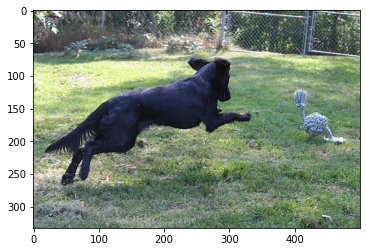

Caption: black dog is running through the grass


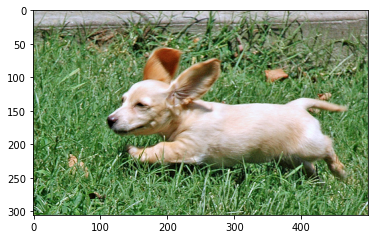

Caption: two dogs are playing on the grass


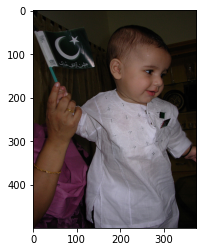

Caption: the boy is wearing red shirt and holding up


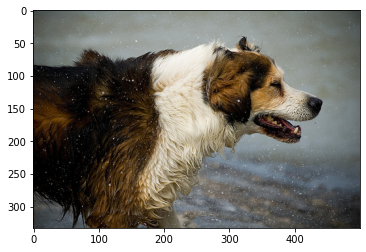

Caption: dog is running through the water


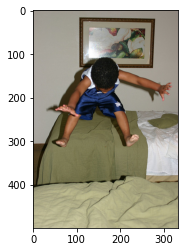

Caption: two girls are playing on bed


In [40]:
for z in range(5,10):
    pic = list(encoding_test.keys())[z]
    image = encoding_test[pic].reshape((1,2048))
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    print("Caption:",generatecaption(image))

## Evaluate Performance on Own Photos

From the below results, the model can perform the image captioning but still, it struggles to captions some images because we have trained the model with only 6k images due to the system hardware constraint.

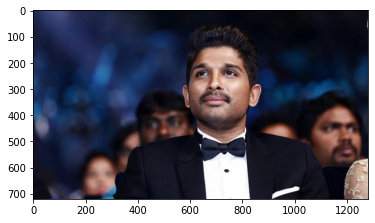

(1, 2048)
Caption: man in black shirt and tie is standing next to man in black shirt and tie





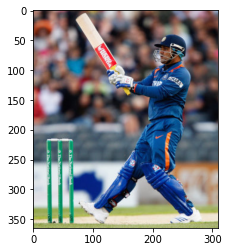

(1, 2048)
Caption: man in red shirt and hat is standing on the grass





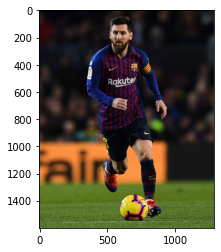

(1, 2048)
Caption: two boys play soccer on the grass





In [56]:
urls = ["https://in.bookmyshow.com/entertainment/wp-content/uploads/2016/04/allu-style-1280x720.jpg",
        "https://www.espncricinfo.com/db/PICTURES/CMS/99300/99389.2.jpg",
        "https://cdn.britannica.com/34/212134-050-A7289400/Lionel-Messi-2018.jpg"]

for url in urls:
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  img.load()
  plt.imshow(img)
  plt.show()
  response = requests.get(url)
  img = encodeImage(img).reshape((1,2048))
  print(img.shape)
  print("Caption:",generatecaption(img))
  print("\n\n")
 

## Challenges:
  
1. Images used for testing must be relevant to those used for training the model. If not, our Machine Learning model will give good results. For instance, If we train our model on the images of man, dogs. we must not test it on images of bike riding etc.
2. As the size of the training dataset increases, the run time of the model would increase rapidly and some cases machine will hung up.

## Future Work
1) Using a larger dataset -- Feeding more trained data to the model will finetune the results resulting in a better understanding of the images. <br>

2) Doing more hyperparameter tuning -- Changing parameters like learning rate, batch size, number of layers, number of units, dropout rate, batch normalization etc. would also enhance our results. <br>

3) Use the cross-validation set to understand overfitting.

## References
1) https://cs.stanford.edu/people/karpathy/cvpr2015.pdf <br>
2) https://arxiv.org/abs/1411.4555 <br>
3) https://arxiv.org/abs/1703.09137 <br>
4) https://arxiv.org/abs/1708.02043 <br>
5) https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/ <br>